# Tutorial: Class Activation Maps for Object Detection with Faster RCNN

![image.png](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both_detection.png)

In this tutorial we're going to see how to apply CAM methods for Object Detection, 
using faster-rcnn from torchvision as an example.


## This is too long, just show me some code !
```python
from pytorch_grad_cam import AblationCAM, EigenCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image

targets = [FasterRCNNBoxScoreTarget(labels=labels, bounding_boxes=boxes)]
target_layers = [model.backbone]
cam = AblationCAM(model,
                  target_layers, 
                  use_cuda=torch.nn.cuda.is_available(), 
                  reshape_transform=fasterrcnn_reshape_transform,
                  ablation_layer=AblationLayerFasterRCNN(),
                  ratio_channels_to_ablate=1.0)

# or a very fast alternative:

cam = EigenCAM(model,
              target_layers, 
              use_cuda=torch.nn.cuda.is_available(), 
              reshape_transform=fasterrcnn_reshape_transform)

```


# Introduction

## Why is it more difficult computing CAMs for object detection?
Object detection packages typically do a lot of processing on the results before they output it:
they create dictionaries with the bounding boxes, labels and scores, do an argmax on the scores to find the highest scoring category, etc.

Because of this, typically the outputs from object detection package are not differentiable
(and it's a common request for the maintainers of those in order to support CAMs).


This means that if we need to compute gradients, there is no "generic" way of doing that, we would have to dive into the code of those packages and do something custom each time, if it's possible at all.

That's not so good for us, since we want to be able to work with existing object detection packages..


CAM methods can be divided into two groups:
- Those that need gradients: GradCAM, GradCAM++, LayerCAM, etc.
- Those that are "gradient free": AblationCAM, ScoreCAM, and EigenCAM.


## Gradient Free Methods to the rescue!

Luckily, we have "Gradient Free Methods", and we can use them for many more use cases compared to "gradient" methods.

We're going to use the next methods here for object detection:
- EigenCAM: this method is extremely fast, but doesn't have good enough class discribination (that's less of an issue for object detection, though).
- AblationCAM: A state of the art method, but slower.
- We're going to see how we can potentially make AblationCAM much faster by controlling the parameter ratio_channels_to_ablate.

Along the way, we're going to use two important concepts in the grad-cam package:
- Writing a custom "reshape" transform to aggregate the activations saved inside faster-rccnn feature pyramid network.
**This is the most important part** - you can use this as a starting point for other object detection networks.


- Writing a custom "target" function for generating CAMs that maximize something about the bounding boxes: like their score, or their intersection over union with the original bounding boxes.


Lets get started!

Lets import the packages we're going to use, define the category names, and a function to run the model and gets the predictions.
Nothing here is related to Class Activation Maps, yet.

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import cv2
import numpy as np
import torch
import torchvision
from pytorch_grad_cam import AblationCAM, EigenCAM, GradCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image

In [2]:
def predict(input_tensor, model, device, detection_threshold):
    outputs = model(input_tensor)
    # print(outputs[0]['labels'].cpu().numpy())
    pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]
    pred_labels = outputs[0]['labels'].cpu().numpy()
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    
    boxes, classes, labels, indices = [], [], [], []
    for index in range(len(pred_scores)):
        if pred_scores[index] >= detection_threshold:
            boxes.append(pred_bboxes[index].astype(np.int32))
            classes.append(pred_classes[index])
            labels.append(pred_labels[index])
            indices.append(index)
    boxes = np.int32(boxes)
    return boxes, classes, labels, indices

def draw_boxes(boxes, labels, classes, image):
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1] - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return image

# coco_names = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', \
#               'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 
#               'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 
#               'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella',
#               'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
#               'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
#               'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork',
#               'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
#               'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
#               'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet',
#               'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
#               'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase',
#               'scissors', 'teddy bear', 'hair drier', 'toothbrush']

coco_names=['__background__',
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]
# This will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))


Now we're going to define the model, read an image, and run the prediction once so we get the detected objects.

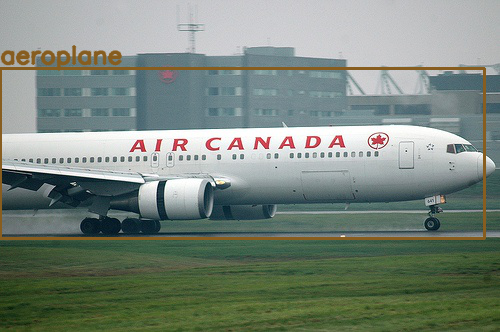

In [3]:
import requests
import torchvision
from PIL import Image
import sys
sys.path.insert(0, '/home/jingchen/faster_rcnn')
from backbone import resnet50_fpn_backbone
from network_files import FasterRCNN


# image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
image_dir = "/home/jingchen/dataset/VOCdevkit/VOC2012/JPEGImages/2007_000738.jpg"
# image = np.array(Image.open(requests.get(image_url, stream=True).raw))
image = np.array(Image.open(image_dir))
image_float_np = np.float32(image) / 255
# define the torchvision image transforms
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

input_tensor = transform(image)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)
# Add a batch dimension:
input_tensor = input_tensor.unsqueeze(0)

# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# model.eval().to(device)


backbone = resnet50_fpn_backbone(norm_layer=torch.nn.BatchNorm2d)
model = FasterRCNN(backbone=backbone, num_classes=21)

# 载入你自己训练好的模型权重
weights_path = "/home/jingchen/faster_rcnn/ori_save_weights/resNetFpn-model-10.pth"
weights_dict = torch.load(weights_path, map_location='cpu')
weights_dict = weights_dict["model"] if "model" in weights_dict else weights_dict
model.load_state_dict(weights_dict)
model.eval().to(device)



# Run the model and display the detections
boxes, classes, labels, indices = predict(input_tensor, model, device, 0.9)
image = draw_boxes(boxes, labels, classes, image)

# Show the image:
Image.fromarray(image)

# What faster-rcnn layer should we target?

The first part of faster-rcnn, is the Feature Pyramid Network (FPN) backbone: model.backbone.
This part is what computes the meaningful activations, and we are going to work with these.

The rest of the network extract features from here and then predicts bounding boxes, but everything is based on the features computed from the FPN.

## Problem: The output from model.backbone is in a very custom format
The backbone outputs 5 different tensors with different spatial sizes, from the FPN.
They are stored as an Ordered Dict.

Our goal here is to aggregate these image tensors, assign them weights, and then aggregate everything.

To do that, we're going to need to write a custom function that takes these tensors with different sizes, resizes them to a common shape, and concatenates them:

```python
def fasterrcnn_reshape_transform(x):
    target_size = x['pool'].size()[-2 : ]
    activations = []
    for key, value in x.items():
        activations.append(torch.nn.functional.interpolate(torch.abs(value), target_size, mode='bilinear'))
    activations = torch.cat(activations, axis=1)
    return activations
```

One more thing - notice that we're taking torch.abs(value) on the activations.

This is one way object detection differs quite a lot from the usual classification networks that have ReLU non linearities. The FPN activations are un-bounded and can have negative values as well.

## What target are the Class Activation Maps created for?

Remember that in the case of classification, we create the CAM for a specific category.
For example, if we want to see which activations respond to "Cat", we could use the 281 image-net category.
And the CAM is computed for that target, with ClassifierOutputTarget(281).


We're going to define something like that for object detection as well.
In the case of object detection, the output of the model are bounding boxes and their categories.
Unfortunately, faster-rcnn doesn't return us scores for all of the categories, it just returns the highest scoring category, so we're going to be limitted to that.

Now the target isn't just limitted to the classification score, it can also be something about the bounding boxes boordinates:
- Maybe we want to find the activations that correspond to the category of the bounding boxes.
- Maybe we want to find the activations that correspond to the coordinates of the bounding boxes, or some property of them, like their width or height.
- Maybe a combination of both the category and a property of the bounding box coordinates.


### We can measure how the detected objects correspond with the original detections in both coordinates and score
We have an output from the model.
We need to assign it some score, so we can highlight the parts of the image that maximize that score.
We can check how the model output corresponds with the original detections:
1. For every bounding box from the original detections, find the detection that overlaps with it the most.
    * Check if the IOU of the detection with the original detection is high enough - if not, assign a score of 0 to the box.
    * Check if the category is still the same as in the original detection - if not, assign a score of 0 to the box.
    * Find the classification score.
    * box_score = IOU + classification_score.
2. target = sum(box_scores)

Lets look at that (defined in pytorch_grad_cam.utils.model_targets.FasterRCNNBoxScoreTarget):

```python
class FasterRCNNBoxScoreTarget:
	""" For every original detected bounding box specified in "bounding boxes",
		assign a score on how the current bounding boxes match it,
			1. In IOU
			2. In the classification score.
		If there is not a large enough overlap, or the category changed,
		assign a score of 0.

		The total score is the sum of all the box scores.
	"""

    def __init__(self, labels, bounding_boxes, iou_threshold=0.5):
        self.labels = labels
        self.bounding_boxes = bounding_boxes
        self.iou_threshold = iou_threshold

    def __call__(self, model_outputs):
        output = torch.Tensor([0])
        if torch.cuda.is_available():
            output = output.cuda()

        if len(model_outputs["boxes"]) == 0:
            return output

        for box, label in zip(self.bounding_boxes, self.labels):
            box = torch.Tensor(box[None, :])
            if torch.cuda.is_available():
                box = box.cuda()

            ious = torchvision.ops.box_iou(box, model_outputs["boxes"])
            index = ious.argmax()
            if ious[0, index] > self.iou_threshold and model_outputs["labels"][index] == label:
                score = ious[0, index] + model_outputs["scores"][index]
                output = output + score
        return output
```

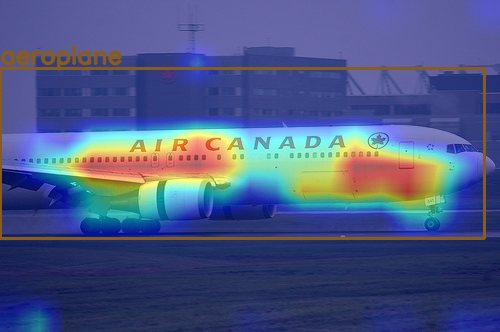

In [4]:
target_layers = [model.backbone]
targets = [FasterRCNNBoxScoreTarget(labels=labels, bounding_boxes=boxes)]
# cam = GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available(), reshape_transform=fasterrcnn_reshape_transform)

# # # targets = [ClassifierOutputTarget(281)]

# # # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# # grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# # # In this example grayscale_cam has only one image in the batch:
# # grayscale_cam = grayscale_cam[0, :]
# # visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

cam = EigenCAM(model,
               target_layers, 
               use_cuda=torch.cuda.is_available(),
               reshape_transform=fasterrcnn_reshape_transform)

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
# Take the first image in the batch:
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
# And lets draw the boxes again:
image_with_bounding_boxes = draw_boxes(boxes, labels, classes, cam_image)
Image.fromarray(image_with_bounding_boxes)

# Optional: Renormalizing the CAMs inside every bounding box
This shows us the CAM computed accross the entire image, normalized to be between 0 and 1, using even pixels that are outside the boxes.
We can re-normalize the CAM inside every bounding box, and take the maximum value in the overlaps between the boxes.

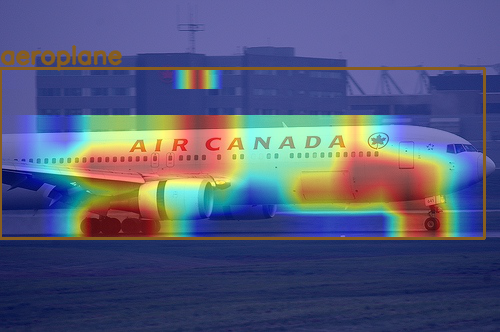

In [5]:
def renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    images = []
    for x1, y1, x2, y2 in boxes:
        img = renormalized_cam * 0
        img[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
        images.append(img)
    
    renormalized_cam = np.max(np.float32(images), axis = 0)
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_boxes(boxes, labels, classes, eigencam_image_renormalized)
    return image_with_bounding_boxes

Image.fromarray(renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam))

# Advanced: More class descrimination with Ablation CAM

A good property of a CAM method is that it should give us class descrimination - it should be able to highlight only the parts that correspond with a specific category, and not those of other categories.

In the previous section we defined the target.. but we cheated.
EigenCAM doesn't actually know how to use the target - the result from it will be constant regardless of the target.

EigenCAM returns the first principle component of the activations, and that will most the time correspond with the dominant object.
The common case is that inside a bounding box, you're going to have a single object.
What happens if you have several different objects that you want to distinguish between?

To get that kind of "class descrimination", we can use Ablation-CAM.

* Disclaimer: The EigenCAM that we used above is extremely fast since it requires only one forward pass, and in the common case that should be good enough, so you probably can just use it for object detection *

Ablation-CAM will "ablate" activations and measure how the output changes. If the output drops a lot, it means that activation is important and should get a higher weight.

# Defining a custom Ablation Layer
For a custom use case, like we have here, we will have to define our own Ablation layer.
We have "AblationLayerFasterRCNN" defined in pytorch_grad_cam.ablation_layer, but lets go over it.

An ablation layer needs to implement two methods:

```python
def set_next_batch(self, input_batch_index, activations, num_channels_to_ablate)
def __call__(self, x)
```

- set_next_batch gets the activations saved in the target layer, those that should get ablated.
It extracts the next batch member from the activations (we're running this method on an input tensor of shape Batch x 3 x Height x Width),
and it needs to repeat it num_channels_to_ablate times.

The ablation layer needs that because it's going to take each of those num_channels_to_ablate and ablate it, in a batch of size num_channels_to_ablate, to make it faster.
There is an outer loop that does this for every input image in the original batch.

- __call__(self, x) is what does the actual ablation.

self.indices contains the next group of indices that should be ablated.

In the case of the FPN network in Faster-RCNN, remember we have a spatial pyramid stored in an Ordered dict.
5 spatial layers total (the '0', '1', '2', '3' and 'pool' keys), each has 256 activations, so a total of 5 * 256 activations/
Remember that when we stored the activations for the CAM, we stacked them on top of each other.
So we need to be able to translate between an index, to the actual layer it corresponds to so we can ablate it.


```python
class AblationLayerFasterRCNN(AblationLayer):
    def __init__(self):
        super(AblationLayerFasterRCNN, self).__init__()

        def set_next_batch(self, input_batch_index, activations, num_channels_to_ablate):
            """ Extract the next batch member from activations,
                and repeat it num_channels_to_ablate times.
            """
            self.activations = OrderedDict()
            for key, value in activations.items():
                fpn_activation = value[input_batch_index, :, :, :].clone().unsqueeze(0)
                self.activations[key] = fpn_activation.repeat(num_channels_to_ablate, 1, 1, 1)

    def __call__(self, x):
        """ Go over the activation indices to be ablated, stored in self.indices.
            Map between every activation index to the tensor in the Ordered Dict from the
            FPN layer.
        """
        result = self.activations
        layers = {0: '0', 1: '1', 2: '2', 3: '3', 4: 'pool'}
        num_channels_to_ablate = result['pool'].size(0)
        for i in range(num_channels_to_ablate):
            pyramid_layer = int(self.indices[i]/256)
            index_in_pyramid_layer = int(self.indices[i] % 256)
            result[layers[pyramid_layer]][i, index_in_pyramid_layer, :, :] = -1000
        return result
```




100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


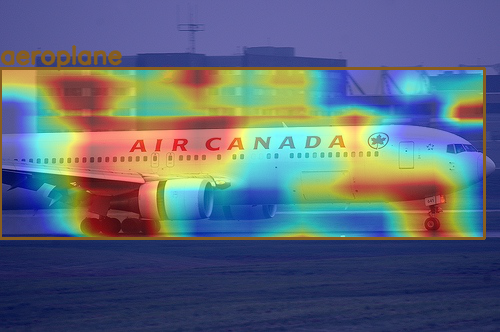

In [6]:
from pytorch_grad_cam import AblationCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
cam = AblationCAM(model,
               target_layers, 
               use_cuda=torch.cuda.is_available(), 
               reshape_transform=fasterrcnn_reshape_transform,
               ablation_layer=AblationLayerFasterRCNN())

grayscale_cam = cam(input_tensor, targets=targets)[0, :]
Image.fromarray(renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam))

## Making it fast by skipping some channels
We're almost done.
AblationCAM is slow since it has to do many forward passes (in our case: 5 x 256 passes).
However some of the channels can be skipped, for example if their empty.
We have an experimental parameter ratio_channels_to_ablate that controls how many of the channels should be ablated.
It compes the first Principle Component (like in EigenCAM) and then thresholds it with a low threshold to get a binary mask,
and then measures the overlap of every activation with that binary mask.

Lets check how the output looks when we ablate only 10% and then 1% of the channels, resulting in an x10 and x100 speedup:

100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


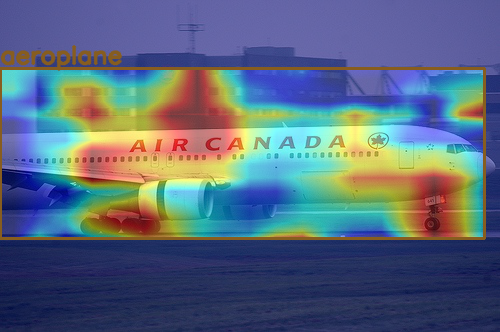

In [7]:
ratio_channels_to_ablate = 0.1
cam = AblationCAM(model,
               target_layers, 
               use_cuda=torch.cuda.is_available(), 
               reshape_transform=fasterrcnn_reshape_transform,
               ablation_layer=AblationLayerFasterRCNN(),
               ratio_channels_to_ablate=ratio_channels_to_ablate)

grayscale_cam = cam(input_tensor, targets=targets)[0, :]
Image.fromarray(renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam))

100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


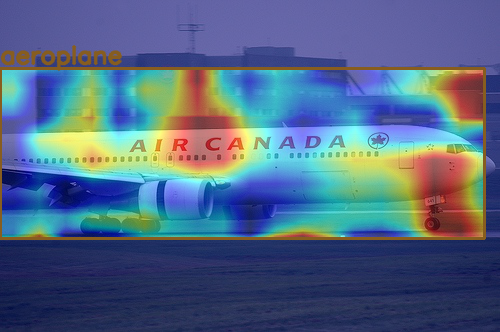

In [8]:
ratio_channels_to_ablate = 0.01
cam = AblationCAM(model,
               target_layers, 
               use_cuda=torch.cuda.is_available(), 
               reshape_transform=fasterrcnn_reshape_transform,
               ablation_layer=AblationLayerFasterRCNN(),
               ratio_channels_to_ablate=ratio_channels_to_ablate)

grayscale_cam = cam(input_tensor, targets=targets)[0, :]
Image.fromarray(renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam))